<a href="https://colab.research.google.com/github/nayoungku1/demuxly/blob/main/multi_sample_trial/demux_version_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
install.packages("reshape2")
install.packages("pheatmap")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [5]:
# ================================
# Cell Ranger Version Comparison Analysis Example
# ================================

library(data.table)
library(dplyr)
library(ggplot2)
library(reshape2)
library(pheatmap)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt




In [6]:
df <- fread("demuxly/multi_sample_trial/PBMC_10k_demux_v8/outs/multi/multiplexing_analysis/tag_calls_per_cell.csv")
colnames(df)
head(df)

[1] "cell_barcode" "num_features" "feature_call" "num_umis"

cell_barcode,num_features,feature_call,num_umis
<chr>,<int>,<chr>,<chr>
AAACCCAAGCAACAGC-1,1,CMO301,16792
AAACCCAAGCTCGTGC-1,1,CMO301,1740
AAACCCACATGACTGT-1,1,CMO301,1626
AAACCCAGTCCACAGC-1,1,CMO301,19325
AAACCCAGTCGCGGTT-1,1,CMO301,1678
AAACCCATCGAAATCC-1,1,CMO301,1916


In [7]:
summary_df <- fread("demuxly/multi_sample_trial/PBMC_10k_demux_v8/outs/multi/multiplexing_analysis/tag_calls_summary.csv")
colnames(summary_df)
head(summary_df)

[1] "Category"    "num_cells"   "pct_cells"   "median_umis" "stddev_umis"

Category,num_cells,pct_cells,median_umis,stddev_umis
<chr>,<int>,<dbl>,<chr>,<chr>
No tag molecules,0,0.0,None,None
No tag assigned,406,3.0,None,None
1 tag assigned,12606,93.5,None,None
More than 1 tag assigned,471,3.5,None,None
CMO301,6512,48.3,3450.5,7980.5
CMO302,6094,45.2,3519.5,5285.0


In [8]:
cat(paste(colnames(summary_df), collapse = "|"))

Category|num_cells|pct_cells|median_umis|stddev_umis

`summarise()` has grouped output by 'version'. You can override using the
`.groups` argument.
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


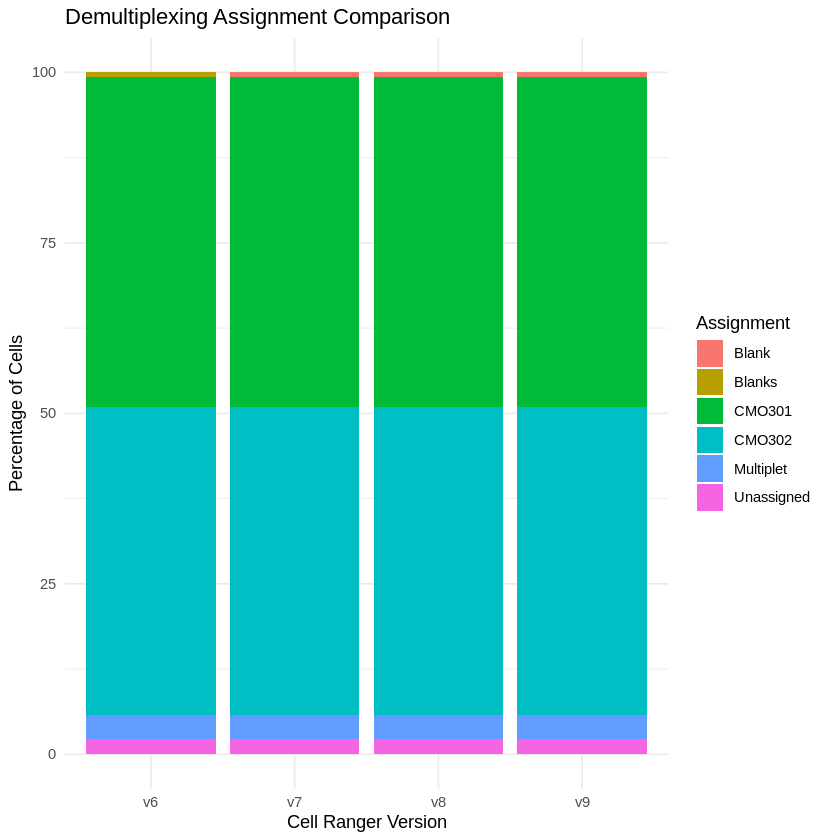

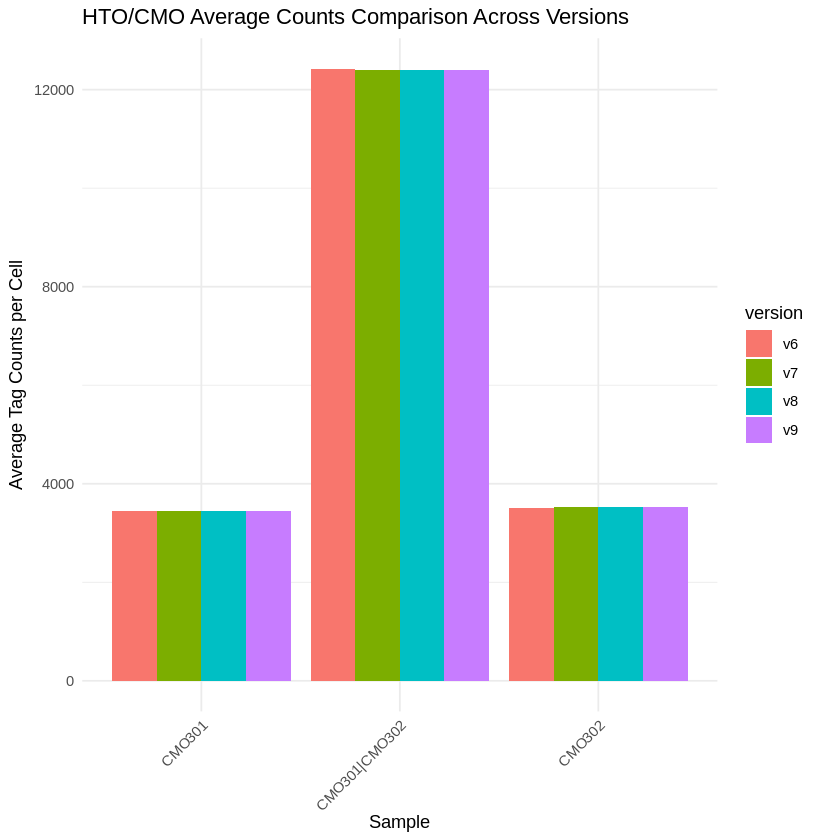

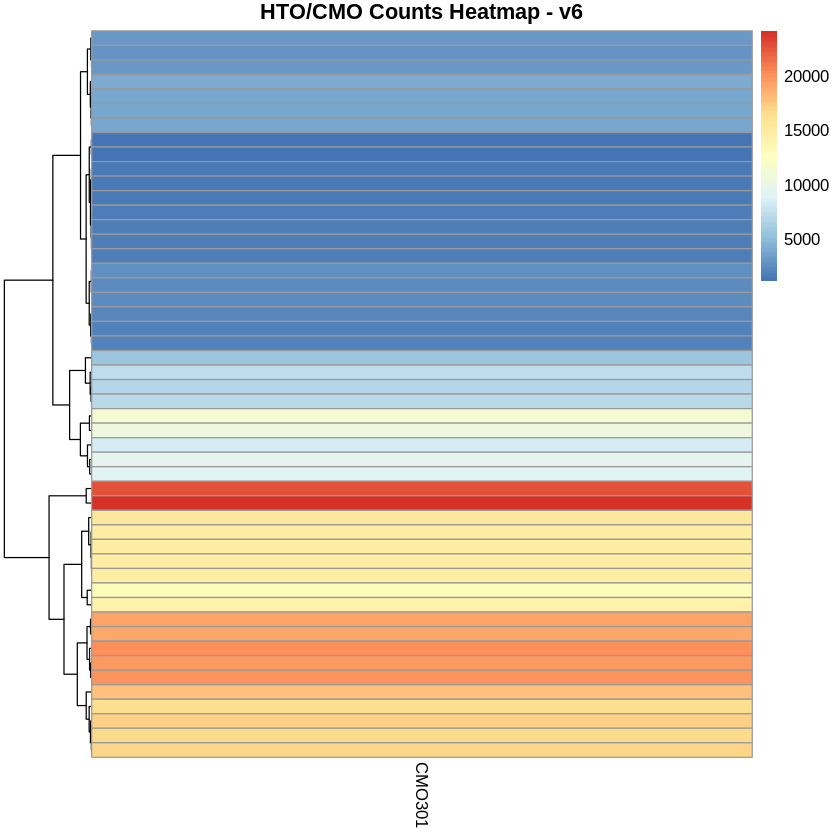

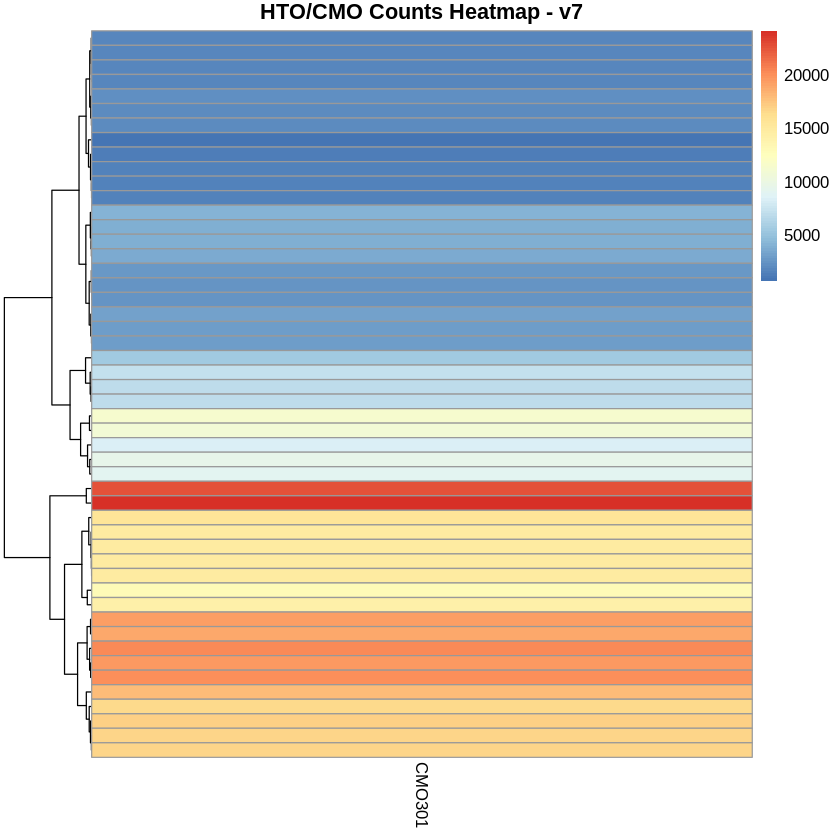

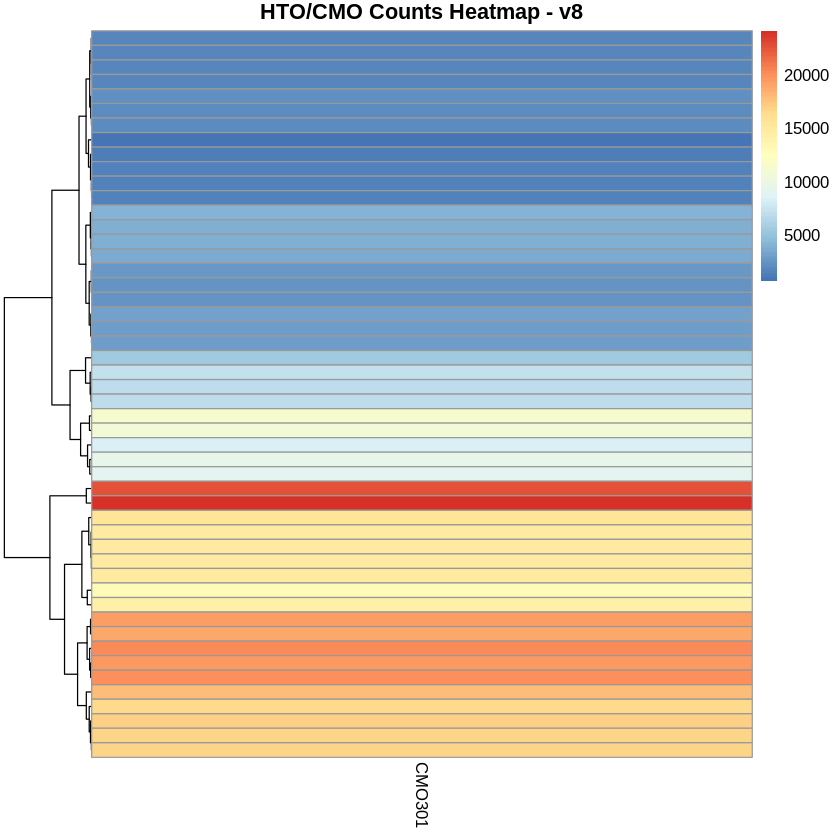

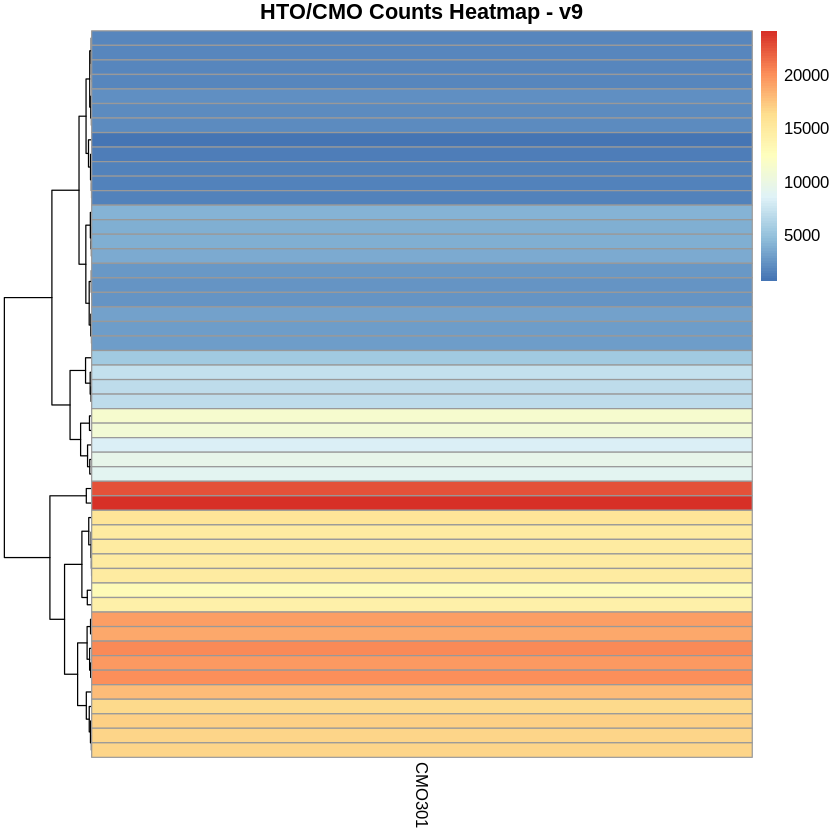

In [12]:
# -------------------------------
# 1. Set file paths for each version
# -------------------------------
versions <- c("v6","v7","v8","v9")

# Folder name for each version
base_path <- "demuxly/multi_sample_trial/PBMC_10k_demux_" # Modify to match actual path

# -------------------------------
# 2. Read assignment_confidence_table.csv
# -------------------------------
assignment_list <- list()

for (v in versions){
  file_path <- paste0(base_path, v, "/outs/multi/multiplexing_analysis/assignment_confidence_table.csv")
  df <- fread(file_path)
  df$version <- v
  assignment_list[[v]] <- df
}

all_assignments <- bind_rows(assignment_list)

# -------------------------------
# 3. Compare Singlet/Multiplet/Negative Ratios
# -------------------------------
qc_summary <- all_assignments %>%
  group_by(version, Assignment) %>%
  summarise(n_cells = n()) %>%
  mutate(percentage = n_cells / sum(n_cells) * 100)

# Visualization
ggplot(qc_summary, aes(x=version, y=percentage, fill=Assignment)) +
  geom_bar(stat="identity", position="stack") +
  ylab("Percentage of Cells") +
  xlab("Cell Ranger Version") +
  ggtitle("Demultiplexing Assignment Comparison") +
  theme_minimal()

# -------------------------------
# 4. Read and compare tag_calls_summary.csv
# -------------------------------
summary_list <- list()

for (v in versions){
  file_path <- paste0(base_path, v, "/outs/multi/multiplexing_analysis/tag_calls_summary.csv")
  df <- fread(file_path)

  # convert median_umis into numeric
  df$median_umis <- as.numeric(df$median_umis)

  df <- df[grepl("^CMO", df$Category), ]

  df$version <- v
  summary_list[[v]] <- df
}

all_summary <- bind_rows(summary_list)

# Example: Compare average tag counts per sample (bar plot)
ggplot(all_summary, aes(x=Category, y=median_umis, fill=version)) +
  geom_bar(stat="identity", position="dodge") +
  ylab("Average Tag Counts per Cell") +
  xlab("Sample") +
  ggtitle("HTO/CMO Average Counts Comparison Across Versions") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# -------------------------------
# 5. Compare HTO/CMO counts heatmap
# -------------------------------
# Example: top 50 cells for each version
for (v in versions){
  file_path <- paste0(base_path, v, "/outs/multi/multiplexing_analysis/tag_calls_per_cell.csv")
  df <- fread(file_path)
  top_cells <- df[1:50, ]

  # Convert num_umis to numeric
  top_cells$num_umis <- as.numeric(top_cells$num_umis)

  # Prepare data for heatmap
  mat <- top_cells[, c("cell_barcode", "feature_call", "num_umis")]
  mat <- dcast(mat, cell_barcode ~ feature_call, value.var = "num_umis", fill = 0)
  rownames(mat) <- mat$cell_barcode
  mat$cell_barcode <- NULL

  # Convert matrix to numeric
  mat <- apply(mat, 2, function(x) as.numeric(as.character(x)))
  mat[is.na(mat)] <- 0

  # Generate heatmap
  pheatmap(mat, cluster_cols=FALSE,
           main=paste("HTO/CMO Counts Heatmap -", v))
}

# -------------------------------
# 6. Compare Singlet Cells (Optional)
# -------------------------------
# Save Singlet barcodes for each version
for (v in versions){
  singlets <- all_assignments %>% filter(version == v, Assignment == "1 tag assigned")
  write.csv(singlets$cell_barcode, paste0("singlets_", v, ".csv"), row.names = FALSE)
}